#使用Resnet50训练面部表情识别模型
source:https://www.kaggle.com/datasets/msambare/fer2013

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# 数据预处理 + 数据batchsize批量化

# DataFrame处理好数据赋值
def create_dataframe_from_folders(base_path):
    data = []
    for emotion_folder in os.listdir(base_path):
        emotion_path = os.path.join(base_path, emotion_folder)
        if os.path.isdir(emotion_path):
            for img_file in os.listdir(emotion_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(emotion_path, img_file)
                    data.append({'image': img_path, 'label': emotion_folder})#把数据打上对应的label
    return pd.DataFrame(data)

train_data = create_dataframe_from_folders('/content/train')
test_data = create_dataframe_from_folders('/content/test')

#所有数据添加对应的标签列，数据初步处理完成
print("添加对应label列:")
print(train_data.shape)
print(train_data.head())




# 标签转数字
labels = train_data['label'].unique()
label_to_num = {label: i for i, label in enumerate(labels)}
train_data['label_num'] = train_data['label'].map(label_to_num)
test_data['label_num'] = test_data['label'].map(label_to_num)

print("标签数量",labels.shape)
print("添加数字列")
print(train_data.shape)
print(train_data.head())


# 自定义Dataset类
class SimpleDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image']
        label = self.data.iloc[idx]['label_num']

        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        return image, label





# 创建数据集和加载器
train_dataset = SimpleDataset(train_data)
test_dataset = SimpleDataset(test_data)

# 批量处理数据
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)#数据打乱并分为64个batch处理
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


print("训练数据信息:")
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"类别分布:\n{train_data['label'].value_counts()}")
print(f"表情类别: {labels}")


# 训练数据加载
images, labels = next(iter(train_loader))
print(f"图片形状: {images.shape}")
print(f"标签形状: {labels.shape}")



添加对应label列:
(28709, 2)
                                      image label
0  /content/train/sad/Training_12951238.jpg   sad
1  /content/train/sad/Training_11036409.jpg   sad
2  /content/train/sad/Training_85053221.jpg   sad
3  /content/train/sad/Training_12312706.jpg   sad
4  /content/train/sad/Training_46656573.jpg   sad
标签数量 (7,)
添加数字列
(28709, 3)
                                      image label  label_num
0  /content/train/sad/Training_12951238.jpg   sad          0
1  /content/train/sad/Training_11036409.jpg   sad          0
2  /content/train/sad/Training_85053221.jpg   sad          0
3  /content/train/sad/Training_12312706.jpg   sad          0
4  /content/train/sad/Training_46656573.jpg   sad          0
训练数据信息:
训练集大小: 28709
测试集大小: 7178
类别分布:
label
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64
表情类别: ['sad' 'neutral' 'happy' 'fear' 'angry' 'disgust' 'surprise']
图片形状: torch.Size([64, 3, 2

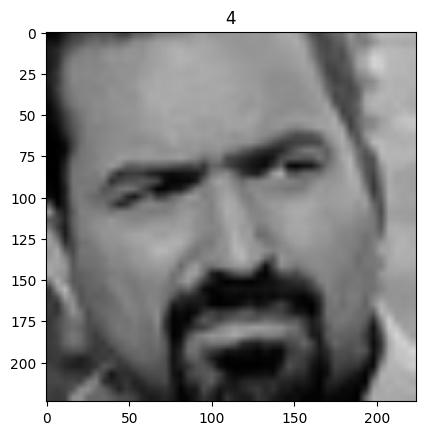

In [3]:
#可视化测试
#表情类别: ['neutral'：0 'angry'：1 'sad'：2 'fear'：3 'surprise'：4 'happy'：5 'disgust'：6]
idx = 50
plt.imshow(images[idx].permute(1, 2, 0))
plt.title(labels[idx].item())
plt.show()

In [8]:
#设置device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
#模型构建
class ResNet50(torch.nn.Module):
    def __init__(self):
      super(ResNet50, self).__init__()
      self.model = models.resnet50(pretrained=True)
      self.model.fc = nn.Linear(2048, 7)
    def forward(self, x):
      x = self.model(x)
      return x

#查看模型结构
model = ResNet50()

model.to(device)
# 指定输入尺寸 (channels, height, width)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
#训练和评估


# 设置损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# 设置学习率调度器
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc='Training')
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        # 前向传播
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播
        loss.backward()
        optimizer.step()

        # 统计
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 更新进度条
        train_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# 验证函数
def validate_epoch(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc='Validation')
        for images, labels in test_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            test_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


for epoch in range(15):
    print(f'\nEpoch {epoch+1}/{15}')
    print('-' * 50)

    # 训练
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    # 评估
    eval_loss, eval_acc = validate_epoch(model, test_loader, criterion, device)



Epoch 1/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:22<00:00,  1.39it/s, Loss=1.3987, Acc=44.93%]



Epoch 2/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:23<00:00,  1.39it/s, Loss=1.1572, Acc=52.78%]



Epoch 3/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:22<00:00,  1.39it/s, Loss=1.3234, Acc=55.77%]



Epoch 4/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:20<00:00,  1.40it/s, Loss=1.1744, Acc=57.83%]



Epoch 5/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:19<00:00,  1.41it/s, Loss=1.1573, Acc=59.86%]



Epoch 6/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:18<00:00,  1.41it/s, Loss=1.2153, Acc=61.38%]



Epoch 7/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:17<00:00,  1.41it/s, Loss=0.8752, Acc=63.34%]



Epoch 8/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:16<00:00,  1.42it/s, Loss=1.2652, Acc=64.79%]



Epoch 9/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:14<00:00,  1.43it/s, Loss=1.1352, Acc=66.67%]



Epoch 10/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:14<00:00,  1.43it/s, Loss=1.0170, Acc=68.14%]



Epoch 11/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:13<00:00,  1.43it/s, Loss=0.9306, Acc=70.91%]



Epoch 12/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:12<00:00,  1.44it/s, Loss=0.6762, Acc=73.16%]



Epoch 13/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:11<00:00,  1.44it/s, Loss=0.5546, Acc=75.65%]



Epoch 14/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:10<00:00,  1.44it/s, Loss=0.6095, Acc=78.78%]



Epoch 15/15
--------------------------------------------------


Training: 100%|██████████| 449/449 [05:10<00:00,  1.45it/s, Loss=0.4235, Acc=81.62%]


In [12]:
for epoch in range(15):
    print(f'\nEpoch {epoch+1}/{15}')
    print('-' * 50)

    #评估
    eval_loss, eval_acc = validate_epoch(model, test_loader, criterion, device)


Epoch 1/15
--------------------------------------------------


Validation: 100%|██████████| 113/113 [00:29<00:00,  3.81it/s, Loss=0.3487, Acc=58.60%]



Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 113/113 [00:29<00:00,  3.82it/s, Loss=0.3487, Acc=58.60%]



Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 113/113 [00:29<00:00,  3.85it/s, Loss=0.3487, Acc=58.60%]



Epoch 4/15
--------------------------------------------------


Validation:  44%|████▍     | 50/113 [00:13<00:16,  3.78it/s, Loss=0.2294, Acc=58.50%]


KeyboardInterrupt: 